In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import yfinance as yf
from talib import abstract

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# directly import strategies
SMA = abstract.SMA
EMA = abstract.EMA
MACD = abstract.MACD
RSI = abstract.RSI
STOCH = abstract.STOCH
STOCHRSI = abstract.STOCHRSI

## Getting Data from Yahoo Example
Additional info: https://pypi.org/project/yfinance/

In [3]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
stock = yf.Ticker("^GSPC")

# one way to get data for period of interest
df = stock.history(period="3y")
df

# Other potential fields of interest
# stock.info
# stock.major_holders
# stock.recommendations
# stock.options

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-26,2757.370117,2780.639893,2753.780029,2779.600098,3424650000,0,0
2018-02-27,2780.449951,2789.149902,2744.219971,2744.280029,3745080000,0,0
2018-02-28,2753.780029,2761.520020,2713.540039,2713.830078,4230660000,0,0
2018-03-01,2715.219971,2730.889893,2659.649902,2677.669922,4503970000,0,0
2018-03-02,2658.889893,2696.250000,2647.320068,2691.250000,3882450000,0,0
...,...,...,...,...,...,...,...
2021-02-17,3918.500000,3933.610107,3900.429932,3931.330078,4718280000,0,0
2021-02-18,3915.860107,3921.979980,3885.030029,3913.969971,4773430000,0,0
2021-02-19,3921.159912,3930.409912,3903.070068,3906.709961,4823940000,0,0


## EDA

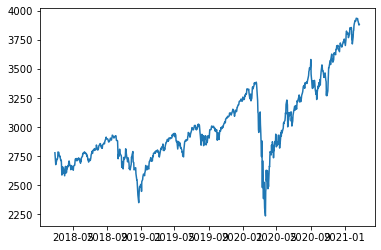

In [4]:
# Simple stock chart based on API data
plt.plot(df.Close)

### Adding Returns Data

In [5]:
# Daily return based on Close price
df["Return"] = df["Close"] - df["Close"].shift(1)
df["Return%"] = df["Return"] / df["Close"]

# Next 5 day return based on Close price
df["N5D_Return"] = (df["Close"] - df["Close"].shift(-5)) * -1+
df["N5D_Return%"] = df["N5D_Return"] / df["Close"]

df.head(10)

SyntaxError: invalid syntax (<ipython-input-5-1283b5d8f1ce>, line 6)

### Adding Common Technical Levels/Signals to the Data

In [ ]:
# Add simple moving averages (SMAs)
df["SMA3"] = SMA(df.Close, 3)
df["SMA5"] = SMA(df.Close, 5)
df["SMA10"] = SMA(df.Close, 10)
df["SMA15"] = SMA(df.Close, 15)
df["SMA20"] = SMA(df.Close, 20)
df["SMA30"] = SMA(df.Close, 30)
df["SMA50"] = SMA(df.Close, 50)

# Add exponential moving averages (EMAs)
# More info: https://www.investopedia.com/terms/e/ema.asp
df["EMA3"] = EMA(df.Close, 3)
df["EMA5"] = EMA(df.Close, 5)
df["EMA10"] = EMA(df.Close, 10)
df["EMA15"] = EMA(df.Close, 15)
df["EMA20"] = EMA(df.Close, 20)
df["EMA30"] = EMA(df.Close, 30)
df["EMA50"] = EMA(df.Close, 50)

# Add pivot point (PP) and classical support and resistance pivot points
# More info: https://www.investopedia.com/terms/p/pivotpoint.asp
df["PP"] = (df.High + df.Low + df.Close) / 3
df["S1C"] = df.PP * 2 - df.High
df["S2C"] = df.PP - (df.High - df.Low)
df["S3C"] = df.Low - 2 * (df.High - df.PP)
df["R1C"] = df.PP * 2 - df.Low 
df["R2C"] = df.PP + (df.High - df.Low)
df["R3C"] = df.High + 2 * (df.PP - df.Low)

# Add Fibonacci support and resistance pivot points
# More info: https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/fibonaccipivotpoints.htm
df["S1F"] = df.PP - 0.382 * (df.High - df.Low)
df["S2F"] = df.PP - 0.618 * (df.High - df.Low)
df["S3F"] = df.PP - 1.0 * (df.High - df.Low)
df["R1F"] = df.PP + 0.382 * (df.High - df.Low)
df["R2F"] = df.PP + 0.618 * (df.High - df.Low)
df["R3F"] = df.PP + 1.0 * (df.High - df.Low)

df

### Adding Other Trading Signals to the Data

In [ ]:
# Add SMA Crossing Signal
sma_fast = SMA(df.Close, 3)
sma_slow = SMA(df.Close, 15)
sma_signal = pd.Series(sma_fast > sma_slow).astype(int).diff().fillna(0)
df["SMA_Signal"] = sma_signal.values

# Add MACD Signal
macd, macdsignal, macdhist = MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
macd_signal = pd.Series(macd > macdsignal).astype(int).diff().fillna(0)
df["MACD_Signal"] = macd_signal.values

# Add RSI Level and Signal
real = RSI(df.Close, timeperiod=14)
df["RSI"] = real
overbought = 70
oversold = 30
buy_signal = pd.Series(real <= oversold).astype(int)
sell_signal = pd.Series(real >= overbought).astype(int) * -1
rsi_signal = buy_signal + sell_signal
df["RSI_Signal"] = rsi_signal.values

# Add Stochastic Oscillator levels
slowk, slowd = STOCH(df.High, df.Low, df.Close, 
                     fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(slowk <= oversold).astype(int) + pd.Series(slowd <= oversold).astype(int)
sell_signal = pd.Series(slowk >= overbought).astype(int) * -1 + pd.Series(slowd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Slow_K"] = slowk
df["Slow_D"] = slowd
df["Stoch_Osci"] = stoch_signal.values

# Add Stochastic RSI levels
fastk, fastd = STOCHRSI(df.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
overbought = 80
oversold = 20
buy_signal = pd.Series(fastk <= oversold).astype(int) + pd.Series(fastd <= oversold).astype(int)
sell_signal = pd.Series(fastk >= overbought).astype(int) * -1 + pd.Series(fastd >= overbought).astype(int) * -1
stoch_signal = buy_signal + sell_signal
df["Fast_K"] = fastk
df["Fast_D"] = fastd
df["Stoch_RSI"] = stoch_signal.values

print(df.shape)
df.describe()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.to_csv("example_data.csv")

### Returns and Signal Visualizations

In [ ]:
plt.hist(df["Return%"])

In [ ]:
plt.plot(df["Return%"])

In [ ]:
plt.hist(df["N5D_Return%"])

In [ ]:
plt.plot(df["N5D_Return%"])

In [ ]:
# Take a look at an example signal plot
plt.plot(df.SMA_Signal)

In [ ]:
# Take a look at an example signal plot
plt.plot(df.MACD_Signal)

In [ ]:
plt.plot(df.RSI)

In [ ]:
plt.plot(df.RSI_Signal)

In [ ]:
plt.scatter(df.SMA_Signal, df["N5D_Return%"])

In [ ]:
plt.scatter(df.MACD_Signal, df["N5D_Return%"])

In [ ]:
plt.scatter(df.RSI, df["N5D_Return%"])

## Trading Signal-Based Strategies
More info: https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html

### Buy and Hold

In [ ]:
class BuyAndHold(Strategy):
    # This strategy actually starts at day 2 of the time period because of the next() method
    def init(self):
        next
    def next(self):
        self.buy()

### SMA Cross

In [ ]:
class SmaCross(Strategy):
    # Define parameters of the strategy
    fast = 3
    slow = 15
    long_only = 1
    
    def init(self):
        # Compute moving averages
        self.fast_sma = self.I(SMA, self.data.Close, self.fast)
        self.slow_sma = self.I(SMA, self.data.Close, self.slow)
            
    def next(self):
        # If fast SMA crosses above slow SMA
        if crossover(self.fast_sma, self.slow_sma):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if fast SMA crosses below slow SMA
        elif crossover(self.slow_sma, self.fast_sma):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### MACD

More info: https://www.investopedia.com/terms/m/macd.asp

In [ ]:
class MacdSignal(Strategy): 
    # Define parameters of the strategy
    fastperiod = 12
    slowperiod = 26
    signalperiod = 9
    long_only = 1
    
    def init(self):
        # Compute MACD
        self.macd, self.macdsignal, self.macdhist = self.I(
             MACD, self.data.Close, self.fastperiod, self.slowperiod, self.signalperiod)
        
    def next(self):
        # If MACD crosses above signal line
        if crossover(self.macd, self.macdsignal):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if MACD crosses below signal line
        elif crossover(self.macdsignal, self.macd):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### RSI
More info: https://www.investopedia.com/terms/r/rsi.asp

In [ ]:
class RsiSignal(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    overbought = 70
    oversold = 30
    long_only = 1
    
    def init(self):
        # Compute RSI
        self.real = self.I(RSI, self.data.Close, self.timeperiod)
        
    def next(self):
        # If RSI enters oversold territory
        if self.real <= self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If RSI enters overbought territory
        elif self.real >= self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic Oscillator
More info: https://www.investopedia.com/terms/s/stochasticoscillator.asp

In [ ]:
class StochOsci(Strategy): 
    # Define parameters of the strategy
    fastk_period = 14
    slowk_period = 3
    slowk_matype = 0
    slowd_period = 3
    slowd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.slowk, self.slowd = self.I(STOCH, self.data.High, self.data.Low, self.data.Close, 
                                        self.fastk_period, self.slowk_period, self.slowk_matype, 
                                        self.slowd_period, self.slowd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.slowk <= self.oversold and self.slowd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.slowk >= self.overbought and self.slowd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Stochastic RSI
More info: https://www.investopedia.com/terms/s/stochrsi.asp

In [ ]:
class StochRsi(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    fastk_period = 14
    fastd_period = 3
    fastd_matype = 0
    overbought = 80
    oversold = 20
    long_only = 1
    
    def init(self):
        # Compute K and D lines
        self.fastk, self.fastd = self.I(STOCHRSI, self.data.Close, self.timeperiod,
                                        self.fastk_period, self.fastd_period, self.fastd_matype)
        
    def next(self):
        # If K and D enter oversold territory
        if self.fastk < self.oversold and self.fastd < self.oversold:
            if self.long_only == 0:
                self.position.close()
            self.buy()
        
        # If K and D enter overbought territory
        elif self.fastk > self.overbought and self.fastd > self.overbought:
            self.position.close()
            if self.long_only == 0:
                self.sell()

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [ ]:
# Specify data timeframe and strategy to test
# Get data from Yahoo
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
# S&P500 index: ^GSPC
data = yf.download("SPY", period="1y")
strategy = BuyAndHold

# Run backtesting
bt = Backtest(data, strategy, cash=100_000, commission=0)
stats = bt.run()

# Display stats and plot results
print(stats)
bt.plot()

In [ ]:
# Contains individual trade data
stats['_trades']

In [ ]:
# Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.
stats['_equity_curve']

Memo: other examples: https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html

### Backtesting Strategy Reliability On Multiple Years

In [ ]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# can also use specify: data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30")
recent_periods = ["6mo", "1y"]
year_periods = [("2015-12-31", "2016-12-31"), ("2016-12-31", "2017-12-31"),
               ("2017-12-31", "2018-12-31"), ("2018-12-31", "2019-12-31"), 
               ("2019-12-31", "2020-12-31")]

strategy = SmaCross

def Backtest_Strategy(ticker, strategy, period):
    
    # Download data depending on type specification
    if type(period) == str:
        data = yf.download(ticker, period=period)
    else:
        data = yf.download(ticker, start=period[0], end=period[1]
    
    # Run backtesting
    bt = Backtest(data, strategy, cash=100_000, commission=0)
    stats = bt.run()
    
    strategy_overview[""]


##### WORKING ON THIS #####
stats["Sharpe Ratio"]

In [ ]:
today = datetime.date.today()
print(today)

In [ ]:
period = ("2016-12-31", "2017-12-31")
period[0]